# Tensor flow GAN on Hband Galaxy cutouts

Last edited by Shooby: May 31, 2019

Read in CANDELS cutout images of galaxies as tensors with Tensorflow and feed that into a GAN. I have changed the input data much to be similar to MNIST in format. The discriminator and generator are copied from the MNIST examples mostly from JonBruner github on GANs, and some from Hvass-labs tutorials of tensorflow. No keras used in this notebook, directly tensorflow. Also, this uses convolutional nn but I am not sure yet, if it counts as a DCGAN or a simple GAN with all nodes connected.

In [1]:
from __future__ import print_function
import tensorflow as tf
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt

## Loading Sample Galaxy data (with MNIST function):

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("gals/")

Extracting gals/train-images-idx3-ubyte.gz
Extracting gals/train-labels-idx1-ubyte.gz
Extracting gals/t10k-images-idx3-ubyte.gz
Extracting gals/t10k-labels-idx1-ubyte.gz


In [4]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

(1, 784)


(1, 784)


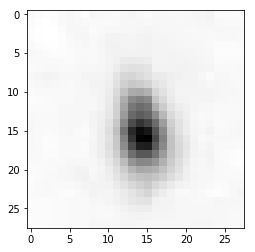

In [9]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image1 = sample_image.reshape([28, 28])
plt.imshow(sample_image1, cmap='Greys')

## The Discriminator and Generator (using simple CNNs)

A neural network with Tensor flow needs: 
    - placeholders for input data and labels (remember to normalize data before training)
    - model variables (weights and biases) 
    - a model (logit) (use a tanh before the output so output is also normalize)
    - a cost function
    - a cost optimization method (Adam is known to be better than stochastic GD)
after all the above is defined, a graph of the tensorflow is built. And a session to run the tensorflow can start

In [10]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

In [11]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='g_b1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='g_b2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='g_b3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

In [13]:
tf.reset_default_graph()
batch_size = 30

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
Dx = discriminator(x_placeholder) 

z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
Gz = generator(z_placeholder, batch_size, z_dimensions) 
Dg = discriminator(Gz, reuse_variables=True)

In [14]:
#defining the cost (loss) functions: 
    
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [15]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

dLossReal: 0.6930823 dLossFake: 0.7110626
dLossReal: 0.44014397 dLossFake: 0.61748827
dLossReal: 0.12833634 dLossFake: 0.065200694
Iteration: 0 at 2019-05-31 17:05:01.454567


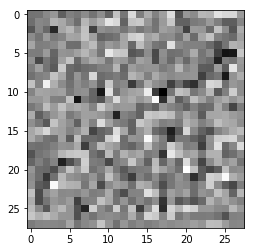

Estimate: [[-13.385868]]
Iteration: 50 at 2019-05-31 17:05:18.256993


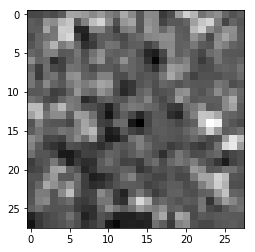

Estimate: [[-5.348904]]
Iteration: 100 at 2019-05-31 17:05:38.709246


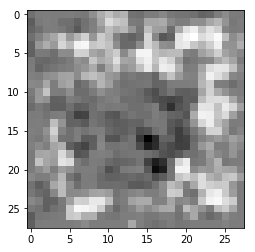

Estimate: [[-5.666181]]
Iteration: 150 at 2019-05-31 17:05:59.600551


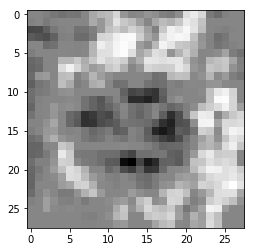

Estimate: [[-8.205361]]
Iteration: 200 at 2019-05-31 17:06:20.120623


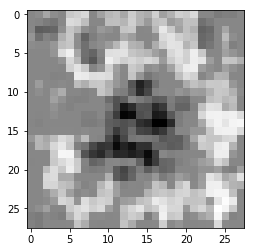

Estimate: [[-7.934602]]
Iteration: 250 at 2019-05-31 17:06:40.504140


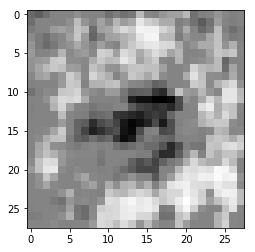

Estimate: [[-7.547212]]
Iteration: 300 at 2019-05-31 17:06:59.912586


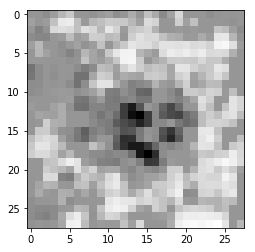

Estimate: [[-4.3162885]]
Iteration: 350 at 2019-05-31 17:07:19.125393


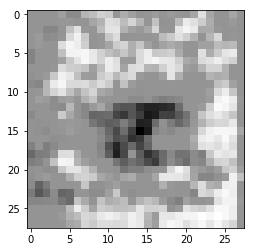

Estimate: [[-7.4905844]]
Iteration: 400 at 2019-05-31 17:07:36.888657


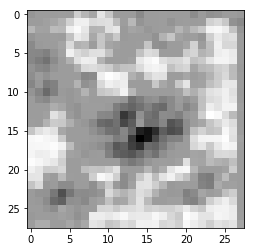

Estimate: [[-7.360687]]
Iteration: 450 at 2019-05-31 17:07:53.808662


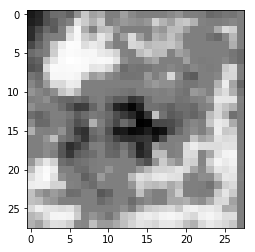

Estimate: [[-10.174169]]
Iteration: 500 at 2019-05-31 17:08:10.918962


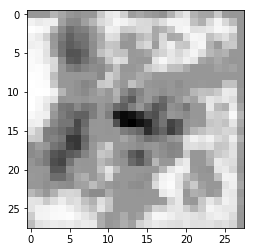

Estimate: [[-5.5879292]]
Iteration: 550 at 2019-05-31 17:08:27.796342


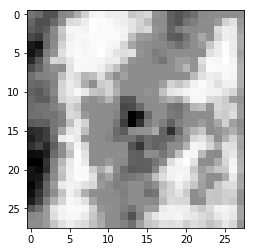

Estimate: [[-9.059182]]
Iteration: 600 at 2019-05-31 17:08:44.912686


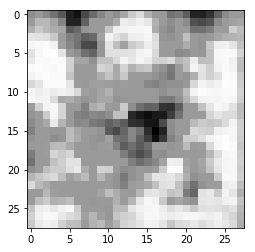

Estimate: [[-4.204401]]
Iteration: 650 at 2019-05-31 17:09:02.828092


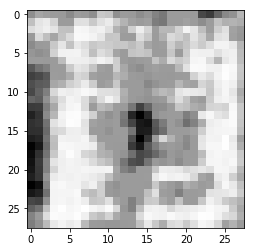

Estimate: [[-5.541788]]
Iteration: 700 at 2019-05-31 17:09:19.897384


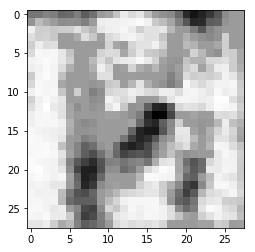

Estimate: [[-3.5982175]]
Iteration: 750 at 2019-05-31 17:09:37.388807


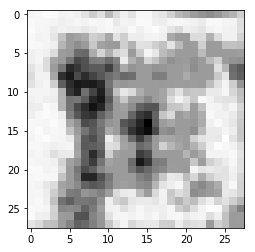

Estimate: [[-3.1131954]]
Iteration: 800 at 2019-05-31 17:09:54.391364


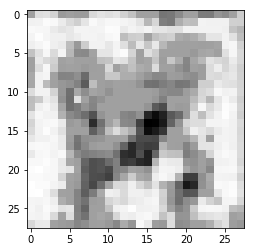

Estimate: [[-3.4623318]]
Iteration: 850 at 2019-05-31 17:10:12.129491


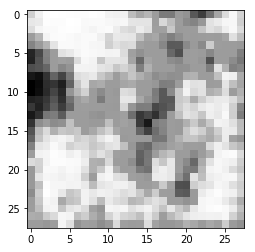

Estimate: [[-2.3388982]]
Iteration: 900 at 2019-05-31 17:10:29.285798


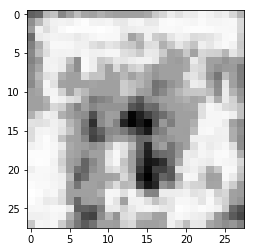

Estimate: [[-4.2468405]]
Iteration: 950 at 2019-05-31 17:10:48.002888


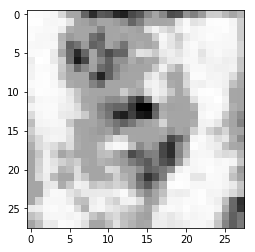

Estimate: [[-7.212969]]
Iteration: 1000 at 2019-05-31 17:11:08.397166


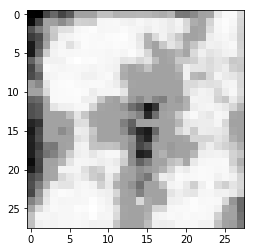

Estimate: [[-6.4506607]]


In [ ]:
tf.get_variable_scope().reuse_variables()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28,28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(2000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28,28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})


    if i % 50 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28,28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)